<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/6_1_attitude_steerability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 6.1: Attitude Steerability

**Research Question:** For which of the 34 attitude variables can the Rep-vs-Dem steering vector push LLM probabilities to match real-world GSS partisan distributions?

In Phase 3.1, we steered Llama-3-8B-Instruct with a `PartyID_Strong Republican - PartyID_Strong Democrat` contrastive vector on 4 policy questions (abortion, gun control, death penalty, same-sex marriage). We found that abortion, gun control, and death penalty could be steered to match real-world GSS partisan distributions, but same-sex marriage could not.

This notebook extends that experiment to **all 34 attitude variables** from Phase 6 to investigate which attitudes are steerable to real-world human levels and which resist steering.

In [1]:
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 38.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
BASE_DIR = '/content/drive/MyDrive/belief_and_llms_v0'
VECTOR_DIR = os.path.join(BASE_DIR, 'vectors')
DATA_DIR = os.path.join(BASE_DIR, 'data')

# Constants
STEERING_LAYER = 13
STRENGTHS = np.arange(-5.0, 5.5, 0.5)

# Load model
model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map='auto',
    torch_dtype=torch.float16,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
print('Model loaded.')

# Load contrastive steering vector: Strong Republican - Strong Democrat
demo_vectors = torch.load(
    os.path.join(VECTOR_DIR, f'gss_demographic_vectors_layer{STEERING_LAYER}.pt'),
    map_location='cpu', weights_only=True,
)
v_rep = demo_vectors['PartyID_Strong Republican']['vector']
v_dem = demo_vectors['PartyID_Strong Democrat']['vector']
contrastive_vec = v_rep - v_dem
print(f'Contrastive vector (Rep - Dem) magnitude: {contrastive_vec.norm():.4f}')
print(f'Steering strengths: {STRENGTHS[0]:.1f} to {STRENGTHS[-1]:.1f} (step 0.5, {len(STRENGTHS)} values)')

Mounted at /content/drive


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Model loaded.
Contrastive vector (Rep - Dem) magnitude: 0.3403
Steering strengths: -5.0 to 5.0 (step 0.5, 21 values)


In [3]:
# All 34 attitude variable configurations
ATTITUDE_CONFIGS = {
    # === Binary Variables ===
    'abortion': {
        'gss_col': 'abany',
        'option_a_label': 'Pro-choice',
        'option_b_label': 'Pro-life',
        'option_a_values': ['YES'],
        'option_b_values': ['NO'],
        'binary_prompt': '[INST] What is your stance on abortion? [/INST]\n(A) Pro-choice (woman should have the right to choose)\n(B) Pro-life (abortion should be restricted or banned)\nAnswer:',
    },
    'gun_control': {
        'gss_col': 'gunlaw',
        'option_a_label': 'Stricter control',
        'option_b_label': 'Gun rights',
        'option_a_values': ['FAVOR'],
        'option_b_values': ['OPPOSE'],
        'binary_prompt': '[INST] What is your stance on gun control? [/INST]\n(A) Support stricter gun control laws\n(B) Protect Second Amendment gun rights\nAnswer:',
    },
    'death_penalty': {
        'gss_col': 'cappun',
        'option_a_label': 'Oppose',
        'option_b_label': 'Favor',
        'option_a_values': ['OPPOSE'],
        'option_b_values': ['FAVOR'],
        'binary_prompt': '[INST] What is your stance on the death penalty for persons convicted of murder? [/INST]\n(A) Oppose the death penalty\n(B) Favor the death penalty\nAnswer:',
    },
    'same_sex_marriage': {
        'gss_col': 'MARSAME1',
        'option_a_label': 'Support',
        'option_b_label': 'Oppose',
        'option_a_values': ['Strongly agree', 'Agree'],
        'option_b_values': ['Disagree', 'Strongly disagree'],
        'binary_prompt': '[INST] What is your stance on same-sex marriage? [/INST]\n(A) Support (same-sex couples should have the right to marry)\n(B) Oppose (marriage should be between a man and a woman)\nAnswer:',
    },
    'free_speech_racists': {
        'gss_col': 'librac',
        'option_a_label': 'Allow',
        'option_b_label': 'Censor',
        'option_a_values': ['NOT REMOVE'],
        'option_b_values': ['REMOVE'],
        'binary_prompt': '[INST] Should a book written by a racist be removed from the public library? [/INST]\n(A) Should not be removed (allow racist speech)\n(B) Should be removed (censor racist speech)\nAnswer:',
    },
    'free_speech_atheists': {
        'gss_col': 'libath',
        'option_a_label': 'Allow',
        'option_b_label': 'Censor',
        'option_a_values': ['NOT REMOVE'],
        'option_b_values': ['REMOVE'],
        'binary_prompt': '[INST] Should a book written against churches and religion be removed from the public library? [/INST]\n(A) Should not be removed (allow atheist speech)\n(B) Should be removed (censor atheist speech)\nAnswer:',
    },
    'marijuana': {
        'gss_col': 'grass',
        'option_a_label': 'Legal',
        'option_b_label': 'Illegal',
        'option_a_values': ['Should be legal'],
        'option_b_values': ['Should not be legal'],
        'binary_prompt': '[INST] Do you think the use of marijuana should be made legal or not? [/INST]\n(A) Should be made legal\n(B) Should not be made legal\nAnswer:',
    },
    'euthanasia': {
        'gss_col': 'letdie1',
        'option_a_label': 'Right to die',
        'option_b_label': 'No right to die',
        'option_a_values': ['YES'],
        'option_b_values': ['NO'],
        'binary_prompt': '[INST] When a person has an incurable disease, should doctors be allowed by law to end the patient\'s life if the patient and family request it? [/INST]\n(A) Yes, doctors should be allowed\n(B) No, doctors should not be allowed\nAnswer:',
    },
    'work_ethic_if_rich': {
        'gss_col': 'richwork',
        'option_a_label': 'Continue working',
        'option_b_label': 'Stop working',
        'option_a_values': ['Continue to work'],
        'option_b_values': ['Stop working'],
        'binary_prompt': '[INST] If you were to get enough money to live comfortably for the rest of your life, would you continue to work or stop working? [/INST]\n(A) Continue to work\n(B) Stop working\nAnswer:',
    },

    # === 3-Option Variables (collapse to 2 extremes) ===
    'spending_space': {
        'gss_col': 'natspac',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on the space exploration program? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_environment': {
        'gss_col': 'natenvir',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on improving and protecting the environment? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_crime': {
        'gss_col': 'natcrime',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on halting the rising crime rate? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_drugs': {
        'gss_col': 'natdrug',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on dealing with drug addiction? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_education': {
        'gss_col': 'nateduc',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on improving the nation\'s education system? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_race': {
        'gss_col': 'natrace',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on improving the conditions of Black Americans? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_military': {
        'gss_col': 'natarms',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on the military, armaments, and defense? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_welfare': {
        'gss_col': 'natfare',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on welfare? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'court_harshness': {
        'gss_col': 'courts',
        'option_a_label': 'Too harsh',
        'option_b_label': 'Not harsh enough',
        'option_a_values': ['Too harshly'],
        'option_b_values': ['Not harshly enough'],
        'binary_prompt': '[INST] In general, do you think the courts in this area deal too harshly or not harshly enough with criminals? [/INST]\n(A) Too harshly\n(B) Not harshly enough\nAnswer:',
    },
    'bible': {
        'gss_col': 'bible',
        'option_a_label': 'Word of God',
        'option_b_label': 'Book of fables',
        'option_a_values': ['Word of god'],
        'option_b_values': ['Ancient book'],
        'binary_prompt': '[INST] Which of these statements comes closest to describing your feelings about the Bible? [/INST]\n(A) The Bible is the actual word of God and is to be taken literally\n(B) The Bible is an ancient book of fables, legends, history, and moral precepts\nAnswer:',
    },
    'trust': {
        'gss_col': 'trust',
        'option_a_label': 'Can be trusted',
        'option_b_label': "Can't be careful",
        'option_a_values': ['Most people can be trusted'],
        'option_b_values': ["Can't be too careful"],
        'binary_prompt': '[INST] Generally speaking, would you say that most people can be trusted or that you can\'t be too careful in dealing with people? [/INST]\n(A) Most people can be trusted\n(B) Can\'t be too careful\nAnswer:',
    },
    'fairness': {
        'gss_col': 'fair',
        'option_a_label': 'Fair',
        'option_b_label': 'Take advantage',
        'option_a_values': ['Would try to be fair'],
        'option_b_values': ['Would take advantage of you'],
        'binary_prompt': '[INST] Do you think most people would try to take advantage of you if they got a chance, or would they try to be fair? [/INST]\n(A) Would try to be fair\n(B) Would try to take advantage\nAnswer:',
    },
    'open_housing': {
        'gss_col': 'racopen',
        'option_a_label': 'Anti-discrimination',
        'option_b_label': 'Allow discrimination',
        'option_a_values': ['Second law'],
        'option_b_values': ['First law'],
        'binary_prompt': '[INST] Suppose there is a community-wide vote on housing policy. Which law would you vote for? [/INST]\n(A) A homeowner cannot refuse to sell to someone because of their race or color (anti-discrimination law)\n(B) A homeowner can decide for themselves whom to sell their house to, even if they prefer not to sell to certain races (right to discriminate)\nAnswer:',
    },

    # === Scale Variables (collapse extreme ends) ===
    'income_equality': {
        'gss_col': 'eqwlth',
        'option_a_label': 'Govt reduce',
        'option_b_label': 'Govt not reduce',
        'option_a_values': ['The government should reduce income differences', '2'],
        'option_b_values': ['6', 'The government should not concern itself with reducing income differences'],
        'binary_prompt': '[INST] Some people think that the government should reduce income differences between the rich and poor. Others think the government should not concern itself with this. What do you think? [/INST]\n(A) The government should reduce income differences\n(B) The government should not concern itself with reducing income differences\nAnswer:',
    },
    'help_poor': {
        'gss_col': 'helppoor',
        'option_a_label': 'Govt action',
        'option_b_label': 'Self-help',
        'option_a_values': ['GOVT ACTION', '2'],
        'option_b_values': ['4', 'PEOPLE HELP SELVES'],
        'binary_prompt': '[INST] Some people think that the government should do everything possible to improve the standard of living of all poor Americans. Others think it is not the government\'s responsibility. What do you think? [/INST]\n(A) Government should act to improve the poor\'s standard of living\n(B) People should help themselves\nAnswer:',
    },
    'healthcare': {
        'gss_col': 'helpsick',
        'option_a_label': 'Govt help',
        'option_b_label': 'Self-help',
        'option_a_values': ['GOVT SHOULD HELP', '2'],
        'option_b_values': ['4', 'PEOPLE HELP SELVES'],
        'binary_prompt': '[INST] Some people think the government should help pay for medical care. Others think people should take care of themselves. What do you think? [/INST]\n(A) Government should help pay for medical care\n(B) People should help themselves\nAnswer:',
    },
    'world_good_evil': {
        'gss_col': 'world1',
        'option_a_label': 'Good',
        'option_b_label': 'Evil',
        'option_a_values': ['WORLD IS GOOD', '2'],
        'option_b_values': ['6', 'WORLD IS EVIL'],
        'binary_prompt': '[INST] Would you say that the world is basically filled with goodness, or would you say that there is much evil in the world? [/INST]\n(A) The world is basically good\n(B) The world is basically evil\nAnswer:',
    },
    'people_good_evil': {
        'gss_col': 'world4',
        'option_a_label': 'Good',
        'option_b_label': 'Evil',
        'option_a_values': ['PEOPLE ARE GOOD', '2'],
        'option_b_values': ['6', 'PEOPLE ARE EVIL'],
        'binary_prompt': '[INST] Would you say that human nature is basically good, or that it is fundamentally perverse and corrupt? [/INST]\n(A) Human nature is basically good\n(B) Human nature is fundamentally perverse and corrupt\nAnswer:',
    },
    'perception_whites': {
        'gss_col': 'workwhts',
        'option_a_label': 'Hard-working',
        'option_b_label': 'Lazy',
        'option_a_values': ['1 - Hard-working', '2'],
        'option_b_values': ['6', '7 - Lazy'],
        'binary_prompt': '[INST] On a scale from hard-working to lazy, where would you rate white people in general? [/INST]\n(A) Hard-working\n(B) Lazy\nAnswer:',
    },
    'perception_blacks': {
        'gss_col': 'workblks',
        'option_a_label': 'Hard-working',
        'option_b_label': 'Lazy',
        'option_a_values': ['1 - Hard-working', '2'],
        'option_b_values': ['6', '7 - Lazy'],
        'binary_prompt': '[INST] On a scale from hard-working to lazy, where would you rate Black people in general? [/INST]\n(A) Hard-working\n(B) Lazy\nAnswer:',
    },
    'perception_hispanics': {
        'gss_col': 'workhsps',
        'option_a_label': 'Hard-working',
        'option_b_label': 'Lazy',
        'option_a_values': ['1 - Hard-working', '2'],
        'option_b_values': ['6', '7 - Lazy'],
        'binary_prompt': '[INST] On a scale from hard-working to lazy, where would you rate Hispanic people in general? [/INST]\n(A) Hard-working\n(B) Lazy\nAnswer:',
    },

    # === 4-Option Variables (collapse to 2 groups) ===
    'affirmative_action': {
        'gss_col': 'affrmact',
        'option_a_label': 'Favor',
        'option_b_label': 'Oppose',
        'option_a_values': ['Strongly favors', 'Not strongly favors'],
        'option_b_values': ['Not strongly opposes', 'Strongly opposes'],
        'binary_prompt': '[INST] What about preferential hiring and promotion of Black Americans? Do you favor or oppose it? [/INST]\n(A) Favor affirmative action\n(B) Oppose affirmative action\nAnswer:',
    },
    'premarital_sex': {
        'gss_col': 'premarsx',
        'option_a_label': 'Not wrong',
        'option_b_label': 'Wrong',
        'option_a_values': ['NOT WRONG AT ALL', 'SOMETIMES WRONG'],
        'option_b_values': ['ALMST ALWAYS WRG', 'ALWAYS WRONG'],
        'binary_prompt': '[INST] If a man and woman have sexual relations before marriage, do you think it is wrong or not wrong? [/INST]\n(A) Not wrong at all or sometimes wrong\n(B) Almost always or always wrong\nAnswer:',
    },
    'extramarital_sex': {
        'gss_col': 'xmarsex',
        'option_a_label': 'Not wrong',
        'option_b_label': 'Wrong',
        'option_a_values': ['NOT WRONG AT ALL', 'SOMETIMES WRONG'],
        'option_b_values': ['ALMST ALWAYS WRG', 'ALWAYS WRONG'],
        'binary_prompt': '[INST] What about a married person having sexual relations with someone other than the marriage partner? Is it wrong or not wrong? [/INST]\n(A) Not wrong at all or sometimes wrong\n(B) Almost always or always wrong\nAnswer:',
    },
    'spanking': {
        'gss_col': 'spanking',
        'option_a_label': 'Appropriate',
        'option_b_label': 'Not appropriate',
        'option_a_values': ['STRONGLY AGREE', 'AGREE'],
        'option_b_values': ['DISAGREE', 'STRONGLY DISAGREE'],
        'binary_prompt': '[INST] Do you strongly agree, agree, disagree, or strongly disagree that it is sometimes necessary to discipline a child with a good, hard spanking? [/INST]\n(A) Agree (spanking is sometimes necessary)\n(B) Disagree (spanking is not appropriate)\nAnswer:',
    },
}

# Group assignments for visualization
VARIABLE_GROUPS = {
    'Social issues': ['abortion', 'gun_control', 'death_penalty', 'same_sex_marriage',
                      'marijuana', 'euthanasia', 'premarital_sex', 'extramarital_sex',
                      'spanking', 'free_speech_racists', 'free_speech_atheists'],
    'Spending': ['spending_space', 'spending_environment', 'spending_crime', 'spending_drugs',
                 'spending_education', 'spending_race', 'spending_military', 'spending_welfare'],
    'Other attitudes': ['income_equality', 'help_poor', 'healthcare', 'court_harshness',
                        'bible', 'trust', 'fairness', 'open_housing',
                        'affirmative_action', 'work_ethic_if_rich',
                        'world_good_evil', 'people_good_evil',
                        'perception_whites', 'perception_blacks', 'perception_hispanics'],
}

print(f'Defined {len(ATTITUDE_CONFIGS)} attitude variable configs')
for group, vars_ in VARIABLE_GROUPS.items():
    print(f'  {group}: {len(vars_)} variables')

Defined 34 attitude variable configs
  Social issues: 11 variables
  Spending: 8 variables
  Other attitudes: 15 variables


In [4]:
# Load GSS data and compute real-world probabilities by party
gss_df = pd.read_excel(os.path.join(DATA_DIR, 'GSS.xlsx'))
print(f'Loaded GSS data: {len(gss_df)} rows')

# PartyID mapping (string values in GSS.xlsx)
PARTYID_MAPPING = {
    'Strong Democrat': 'Strong democrat',
    'Democrat': 'Not very strong democrat',
    'Independent': 'Independent (neither, no response)',
    'Republican': 'Not very strong republican',
    'Strong Republican': 'Strong republican',
}

PARTY_COLORS = {
    'Strong Democrat': '#0015BC',
    'Democrat': '#6699FF',
    'Independent': '#808080',
    'Republican': '#FF6666',
    'Strong Republican': '#E81B23',
}

# Entries to filter out
INVALID_PREFIXES = ('.i:', '.d:', '.n:', '.s:', '.y:')

def compute_gss_probability(gss_df, config, party_gss_value=None):
    """Compute P(Option A) for a given attitude variable and optional party filter."""
    col = config['gss_col']
    if col not in gss_df.columns:
        return None, 0

    df = gss_df if party_gss_value is None else gss_df[gss_df['partyid'] == party_gss_value]

    # Filter out invalid entries
    valid_values = config['option_a_values'] + config['option_b_values']
    valid_df = df[df[col].isin(valid_values)]

    if len(valid_df) == 0:
        return None, 0

    option_a_count = valid_df[col].isin(config['option_a_values']).sum()
    return option_a_count / len(valid_df), len(valid_df)

# Compute probabilities for all variables and parties
gss_probs = {}
print(f'\n{"Variable":<25s} {"GSS col":<12s} {"Str Dem":>8s} {"Dem":>8s} {"Ind":>8s} {"Rep":>8s} {"Str Rep":>8s} {"Overall":>8s}')
print('-' * 95)

skipped = []
for var_name, config in ATTITUDE_CONFIGS.items():
    gss_probs[var_name] = {}

    # Per-party probabilities
    row = f'{var_name:<25s} {config["gss_col"]:<12s}'
    for party_label, party_gss_val in PARTYID_MAPPING.items():
        prob, n = compute_gss_probability(gss_df, config, party_gss_val)
        gss_probs[var_name][party_label] = {'prob_a': prob, 'n': n}
        row += f' {prob:>7.1%}' if prob is not None else f' {"N/A":>7s}'

    # Overall probability
    prob_all, n_all = compute_gss_probability(gss_df, config)
    gss_probs[var_name]['Overall'] = {'prob_a': prob_all, 'n': n_all}
    row += f' {prob_all:>7.1%}' if prob_all is not None else f' {"N/A":>7s}'

    if prob_all is None:
        skipped.append(var_name)
    print(row)

if skipped:
    print(f'\nSkipped (column not found): {skipped}')

Loaded GSS data: 75699 rows

Variable                  GSS col       Str Dem      Dem      Ind      Rep  Str Rep  Overall
-----------------------------------------------------------------------------------------------
abortion                  abany          48.6%   45.9%   43.0%   37.9%   28.8%   43.3%
gun_control               gunlaw         82.9%   80.3%   73.6%   72.3%   62.4%   75.0%
death_penalty             cappun         46.4%   34.8%   31.2%   18.6%   14.9%   31.0%
same_sex_marriage         MARSAME1       63.9%   67.1%   58.3%   44.8%   26.0%   57.4%
free_speech_racists       librac         58.6%   62.8%   64.5%   66.0%   65.7%   64.5%
free_speech_atheists      libath         63.6%   68.3%   71.7%   70.3%   66.0%   70.0%
marijuana                 grass          36.1%   32.5%   38.1%   24.9%   20.8%   33.6%
euthanasia                letdie1        65.4%   70.6%   68.9%   68.6%   58.3%   68.6%
work_ethic_if_rich        richwork       65.3%   67.4%   72.2%   70.3%   67.9%   69.3%

In [5]:
# Steering functions (reused from Phase 3.1)

def get_binary_choice_prob(prompt, steering_vector, strength, layer_idx):
    """Get P(A) vs P(B) with steering applied via forward hook."""
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    steer_vec = steering_vector.to(model.device).to(model.dtype)

    def steering_hook(module, input, output):
        perturbation = steer_vec.view(1, 1, -1) * strength
        if isinstance(output, tuple):
            return (output[0] + perturbation,) + output[1:]
        elif isinstance(output, torch.Tensor):
            return output + perturbation
        return output

    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(steering_hook)
    try:
        with torch.no_grad():
            outputs = model(**inputs)
    finally:
        handle.remove()

    next_token_logits = outputs.logits[0, -1, :]
    id_a = tokenizer.encode(' A', add_special_tokens=False)[-1]
    id_b = tokenizer.encode(' B', add_special_tokens=False)[-1]
    probs = F.softmax(torch.tensor([next_token_logits[id_a], next_token_logits[id_b]]), dim=0)
    return probs[0].item()


def find_optimal_strength(llm_results_df, target_prob):
    """Find steering strength that produces P(A) closest to target."""
    if target_prob is None:
        return None, None
    errors = np.abs(llm_results_df['prob_a'].values - target_prob)
    best_idx = np.argmin(errors)
    return llm_results_df.iloc[best_idx]['strength'], errors[best_idx]


print('Steering functions defined.')

Steering functions defined.


In [6]:
# Run steering sweep for all 34 variables
# Total: 34 variables x 21 strengths = 714 forward passes (~12 min)

# Filter to variables with valid GSS data
active_vars = [v for v in ATTITUDE_CONFIGS if gss_probs[v]['Overall']['prob_a'] is not None]
print(f'Running steering sweep for {len(active_vars)} variables with valid GSS data')
print(f'Strengths: {STRENGTHS[0]:.1f} to {STRENGTHS[-1]:.1f} ({len(STRENGTHS)} values)')
print(f'Total forward passes: {len(active_vars) * len(STRENGTHS)}')

llm_steering_results = {}

for i, var_name in enumerate(active_vars):
    config = ATTITUDE_CONFIGS[var_name]
    prompt = config['binary_prompt']

    results = []
    for strength in STRENGTHS:
        prob_a = get_binary_choice_prob(prompt, contrastive_vec, strength, STEERING_LAYER)
        results.append({'strength': strength, 'prob_a': prob_a})

    llm_steering_results[var_name] = pd.DataFrame(results)
    print(f'  [{i+1}/{len(active_vars)}] {var_name}: '
          f'P(A) range = {llm_steering_results[var_name]["prob_a"].min():.3f} – '
          f'{llm_steering_results[var_name]["prob_a"].max():.3f}')

# Save results
save_path = os.path.join(DATA_DIR, 'attitude_steerability_results.pt')
torch.save({
    'llm_steering_results': {k: v.to_dict() for k, v in llm_steering_results.items()},
    'gss_probs': gss_probs,
    'strengths': STRENGTHS.tolist(),
    'steering_layer': STEERING_LAYER,
}, save_path)
print(f'\nResults saved to {save_path}')

Running steering sweep for 34 variables with valid GSS data
Strengths: -5.0 to 5.0 (21 values)
Total forward passes: 714
  [1/34] abortion: P(A) range = 0.670 – 0.821
  [2/34] gun_control: P(A) range = 0.297 – 0.816
  [3/34] death_penalty: P(A) range = 0.267 – 0.701
  [4/34] same_sex_marriage: P(A) range = 0.876 – 0.924
  [5/34] free_speech_racists: P(A) range = 0.204 – 0.496
  [6/34] free_speech_atheists: P(A) range = 0.995 – 0.998
  [7/34] marijuana: P(A) range = 0.858 – 0.961
  [8/34] euthanasia: P(A) range = 0.712 – 0.769
  [9/34] work_ethic_if_rich: P(A) range = 0.207 – 0.520
  [10/34] spending_space: P(A) range = 0.648 – 0.860
  [11/34] spending_environment: P(A) range = 0.931 – 0.975
  [12/34] spending_crime: P(A) range = 0.845 – 0.944
  [13/34] spending_drugs: P(A) range = 0.857 – 0.959
  [14/34] spending_education: P(A) range = 0.913 – 0.968
  [15/34] spending_race: P(A) range = 0.973 – 0.988
  [16/34] spending_military: P(A) range = 0.142 – 0.347
  [17/34] spending_welfare: P

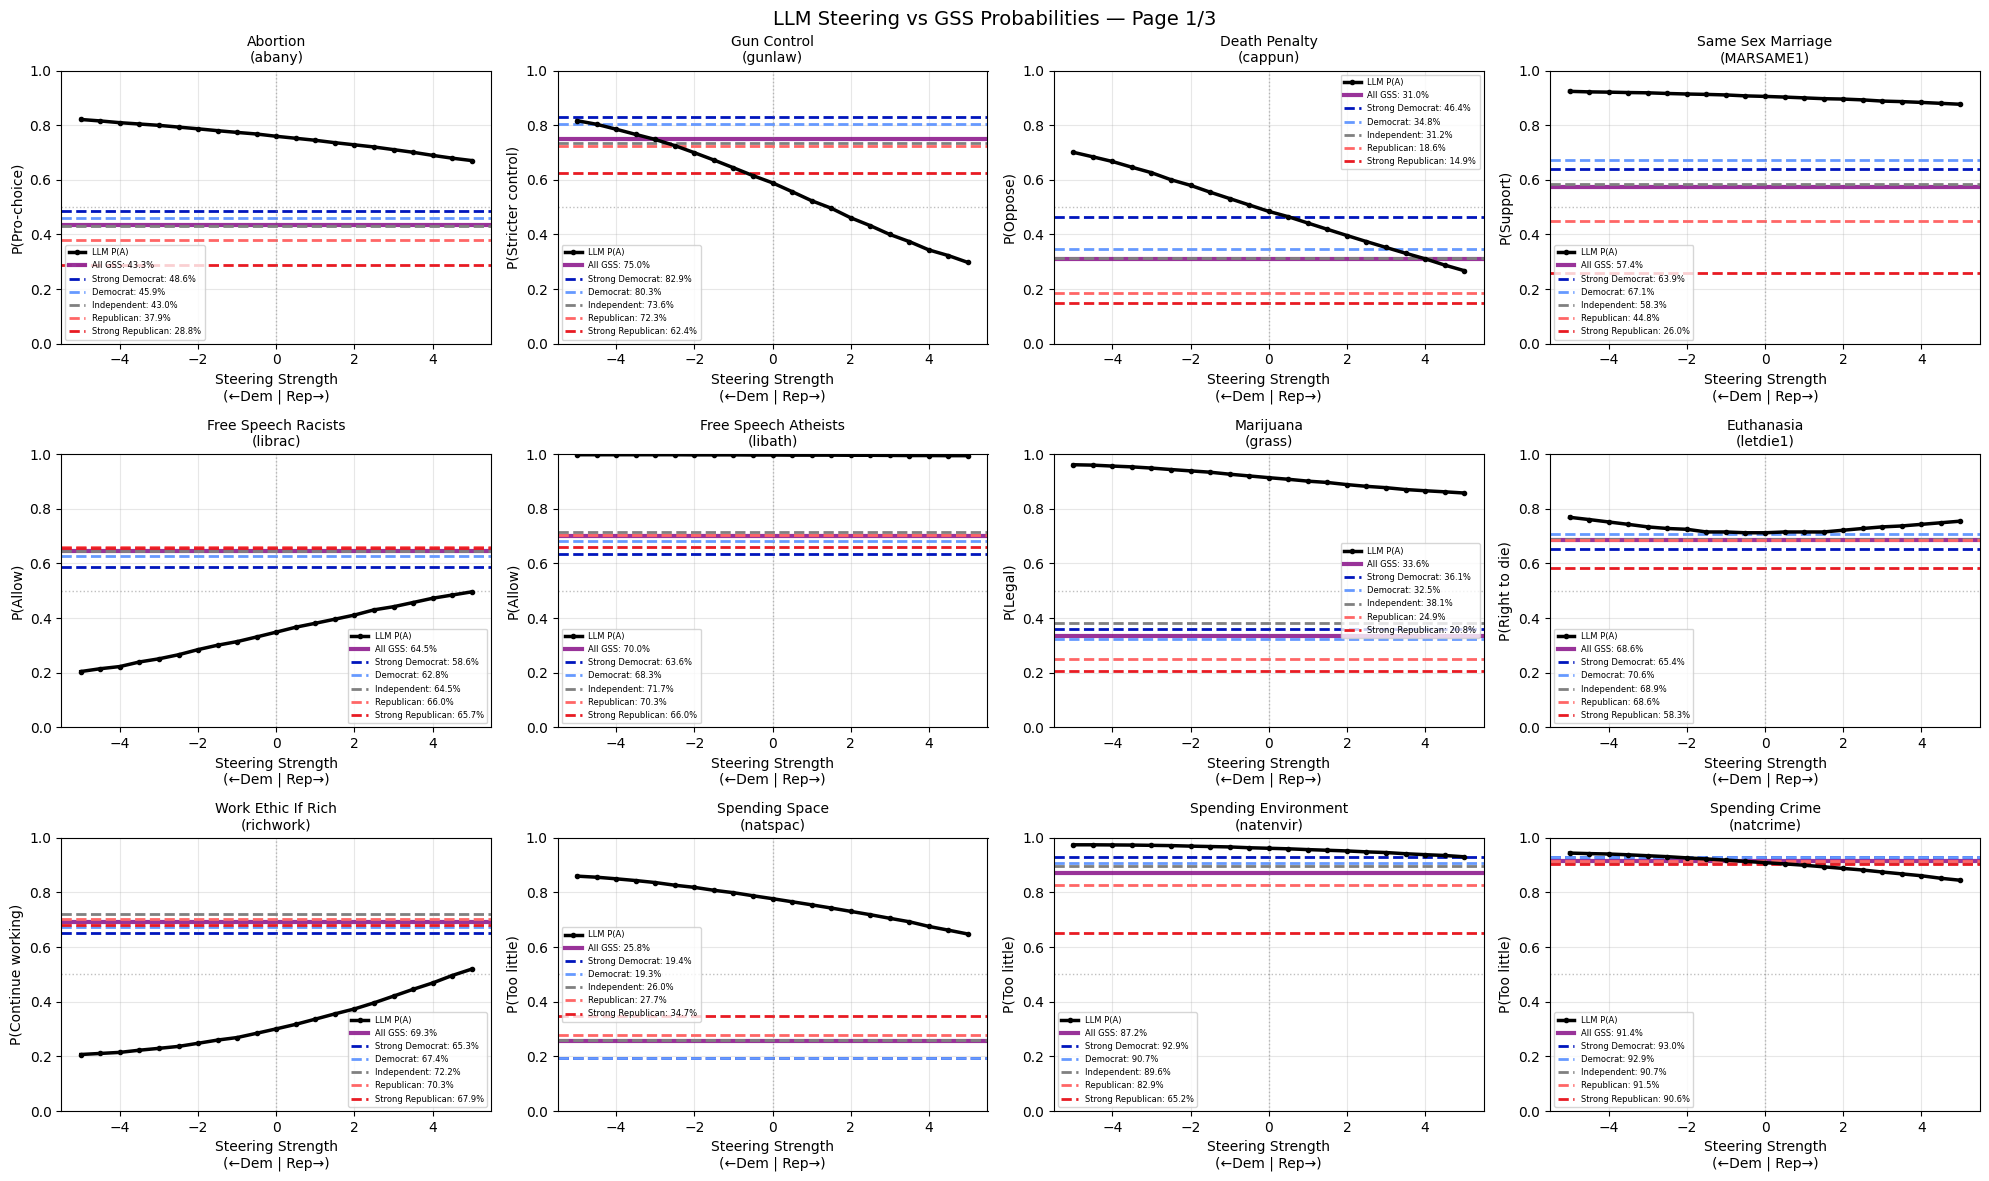

In [7]:
# Visualize: LLM Steering Curves + GSS Target Lines (Page 1: Variables 1-12)
active_vars = list(llm_steering_results.keys())

def plot_steering_page(var_names, page_num, total_pages):
    n = len(var_names)
    ncols = 4
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4 * nrows))
    axes = axes.flatten() if nrows > 1 else (axes if n > 1 else [axes])

    for idx, var_name in enumerate(var_names):
        ax = axes[idx]
        config = ATTITUDE_CONFIGS[var_name]
        llm_df = llm_steering_results[var_name]
        var_gss = gss_probs[var_name]

        # LLM steering curve
        ax.plot(llm_df['strength'], llm_df['prob_a'], 'k-o', linewidth=2.5, markersize=3,
                label='LLM P(A)', zorder=10)

        # Overall GSS line
        overall = var_gss.get('Overall', {})
        if overall.get('prob_a') is not None:
            ax.axhline(y=overall['prob_a'], color='purple', linestyle='-', linewidth=3, alpha=0.8,
                       label=f'All GSS: {overall["prob_a"]:.1%}')

        # Per-party GSS lines
        for party_name in PARTYID_MAPPING:
            party_data = var_gss.get(party_name, {})
            if party_data.get('prob_a') is not None:
                ax.axhline(y=party_data['prob_a'], color=PARTY_COLORS[party_name],
                           linestyle='--', linewidth=2,
                           label=f'{party_name}: {party_data["prob_a"]:.1%}')

        ax.axhline(y=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax.set_xlabel('Steering Strength\n(←Dem | Rep→)')
        ax.set_ylabel(f'P({config["option_a_label"]})')
        ax.set_title(f'{var_name.replace("_", " ").title()}\n({config["gss_col"]})', fontsize=10)
        ax.set_ylim(0, 1)
        ax.legend(loc='best', fontsize=6)
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(n, len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle(f'LLM Steering vs GSS Probabilities — Page {page_num}/{total_pages}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Page 1: Variables 1-12
plot_steering_page(active_vars[:12], 1, 3)

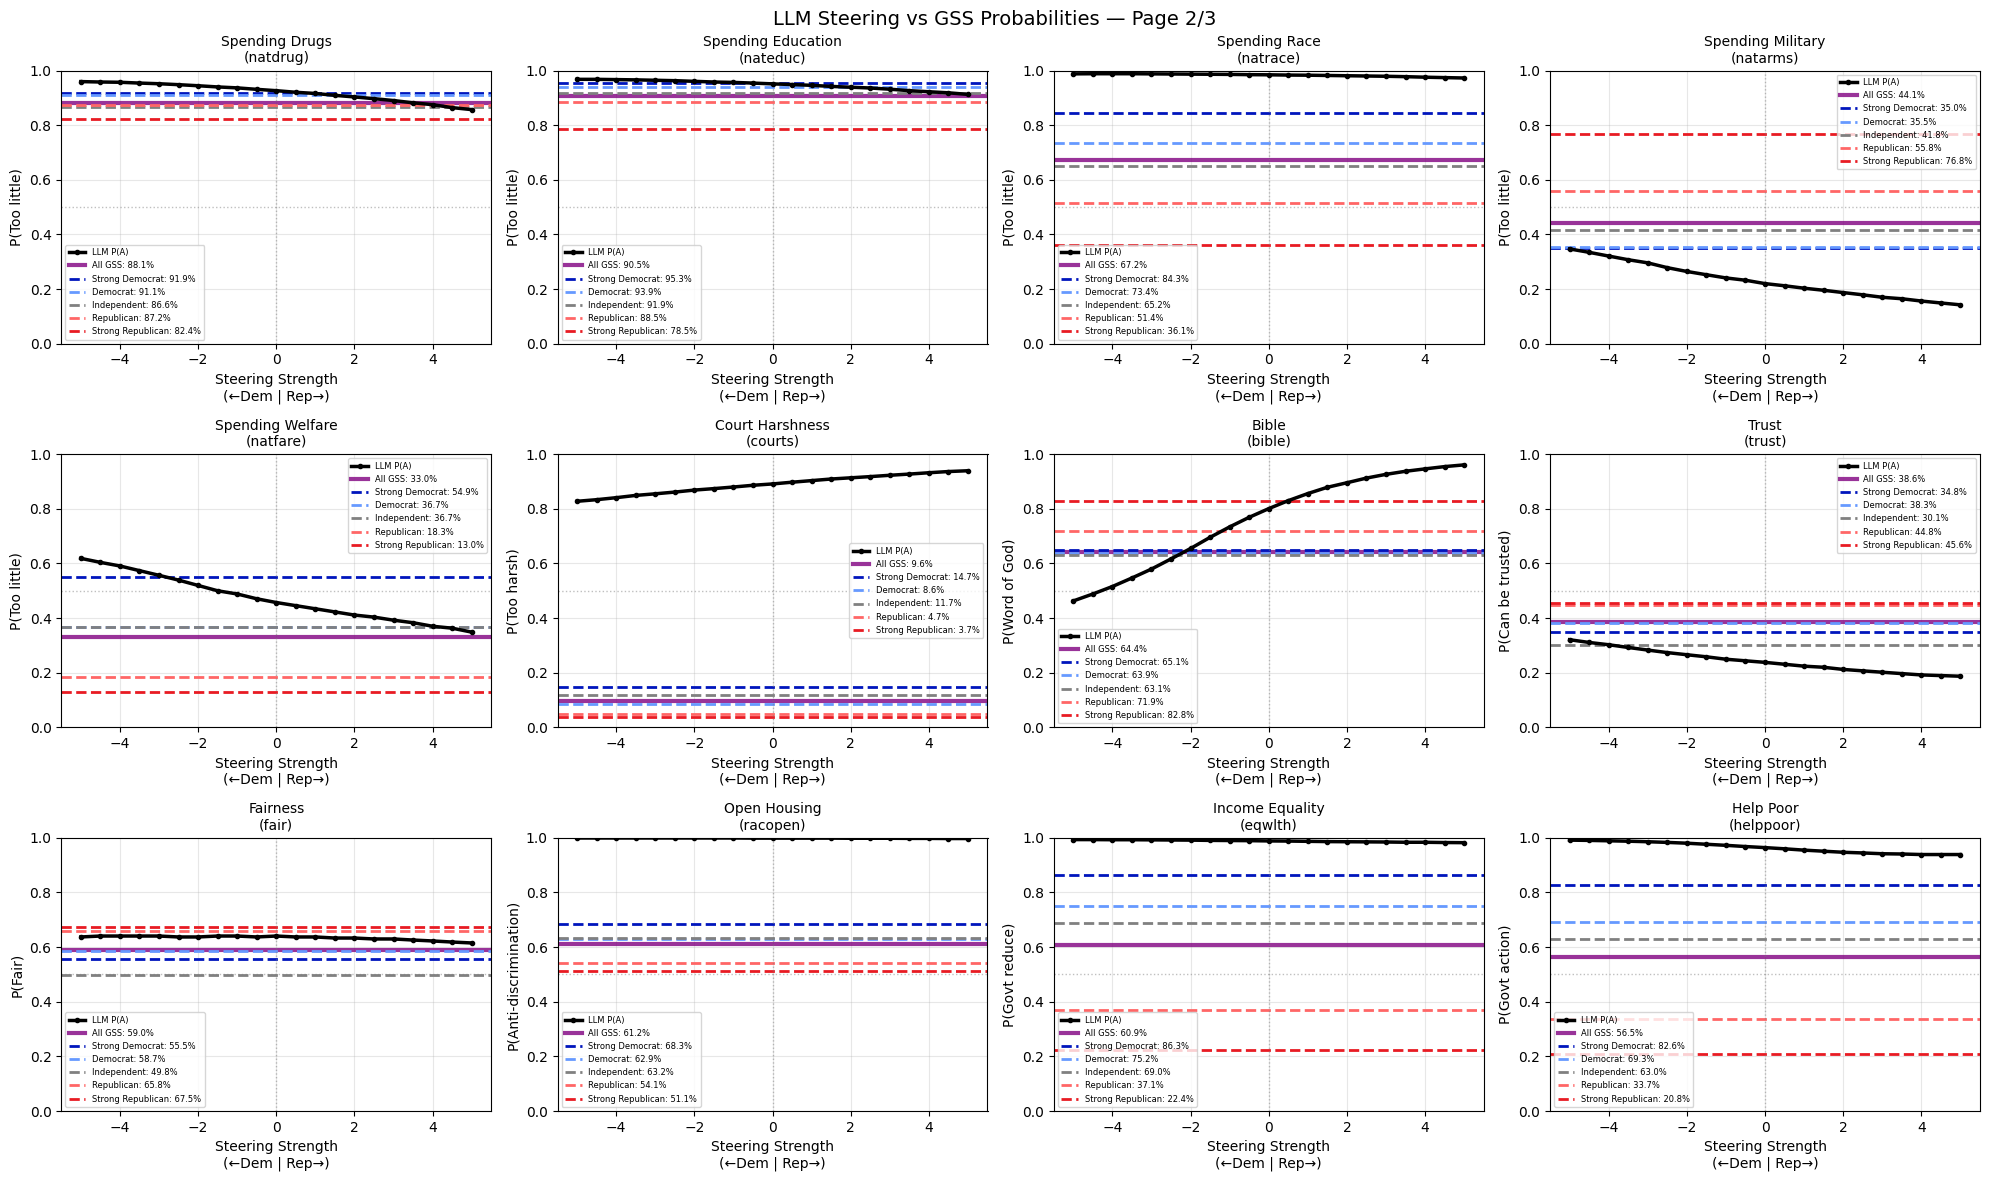

In [8]:
# Page 2: Variables 13-24
plot_steering_page(active_vars[12:24], 2, 3)

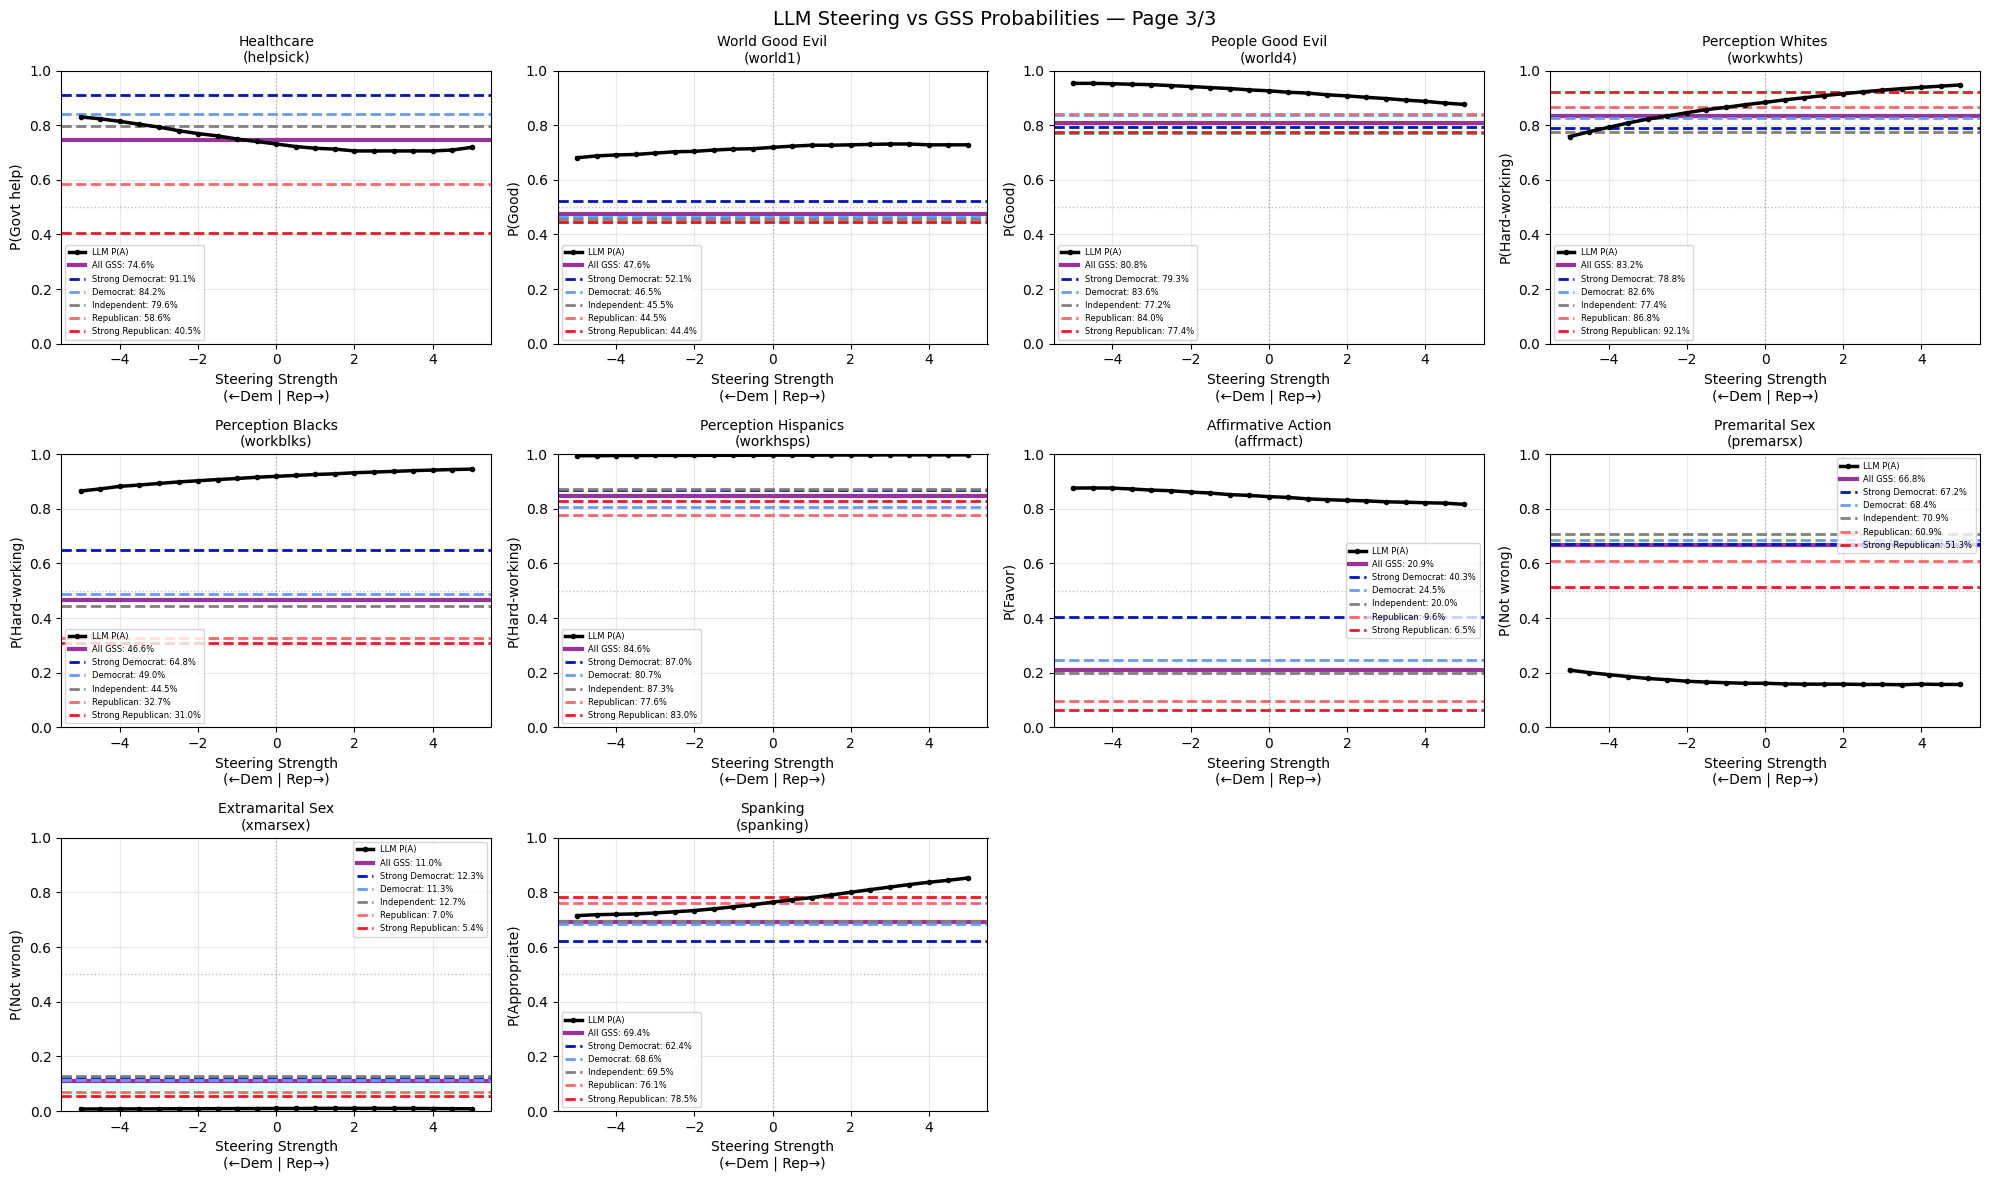

In [9]:
# Page 3: Variables 25-34
plot_steering_page(active_vars[24:], 3, 3)

In [10]:
# Compute steerability metrics
metrics = []

for var_name in active_vars:
    config = ATTITUDE_CONFIGS[var_name]
    llm_df = llm_steering_results[var_name]
    var_gss = gss_probs[var_name]

    llm_min = llm_df['prob_a'].min()
    llm_max = llm_df['prob_a'].max()
    llm_range = llm_max - llm_min

    # Per-party optimal strength and error
    errors = []
    all_reachable = True
    gss_party_probs = []

    for party_name in PARTYID_MAPPING:
        party_data = var_gss.get(party_name, {})
        target = party_data.get('prob_a')
        if target is None:
            continue

        gss_party_probs.append(target)
        _, error = find_optimal_strength(llm_df, target)
        errors.append(error)

        if target < llm_min or target > llm_max:
            all_reachable = False

    gss_spread = max(gss_party_probs) - min(gss_party_probs) if gss_party_probs else 0
    mean_error = np.mean(errors) if errors else None
    max_error = np.max(errors) if errors else None

    # Determine variable group
    group = 'Unknown'
    for g, vars_ in VARIABLE_GROUPS.items():
        if var_name in vars_:
            group = g
            break

    metrics.append({
        'variable': var_name,
        'gss_col': config['gss_col'],
        'group': group,
        'llm_range': llm_range,
        'mean_error': mean_error,
        'max_error': max_error,
        'all_reachable': all_reachable,
        'gss_spread': gss_spread,
    })

metrics_df = pd.DataFrame(metrics).sort_values('mean_error')

print('=== STEERABILITY METRICS (sorted by mean_error, lower = more steerable) ===')
print(f'\n{"Variable":<25s} {"Group":<18s} {"LLM Range":>10s} {"Mean Err":>9s} {"Max Err":>9s} {"GSS Spread":>10s} {"Reachable":>9s}')
print('-' * 95)
for _, row in metrics_df.iterrows():
    print(f'{row["variable"]:<25s} {row["group"]:<18s} '
          f'{row["llm_range"]:>10.3f} {row["mean_error"]:>9.3f} {row["max_error"]:>9.3f} '
          f'{row["gss_spread"]:>10.3f} {"✓" if row["all_reachable"] else "✗":>9s}')

=== STEERABILITY METRICS (sorted by mean_error, lower = more steerable) ===

Variable                  Group               LLM Range  Mean Err   Max Err GSS Spread Reachable
-----------------------------------------------------------------------------------------------
spending_crime            Spending                0.100     0.001     0.002      0.024         ✓
perception_whites         Other attitudes         0.189     0.003     0.004      0.147         ✓
gun_control               Social issues           0.519     0.007     0.012      0.205         ✗
spending_drugs            Spending                0.103     0.008     0.033      0.095         ✗
bible                     Other attitudes         0.498     0.010     0.015      0.197         ✓
spanking                  Social issues           0.138     0.030     0.091      0.161         ✗
spending_education        Spending                0.055     0.032     0.128      0.168         ✗
death_penalty             Social issues           0

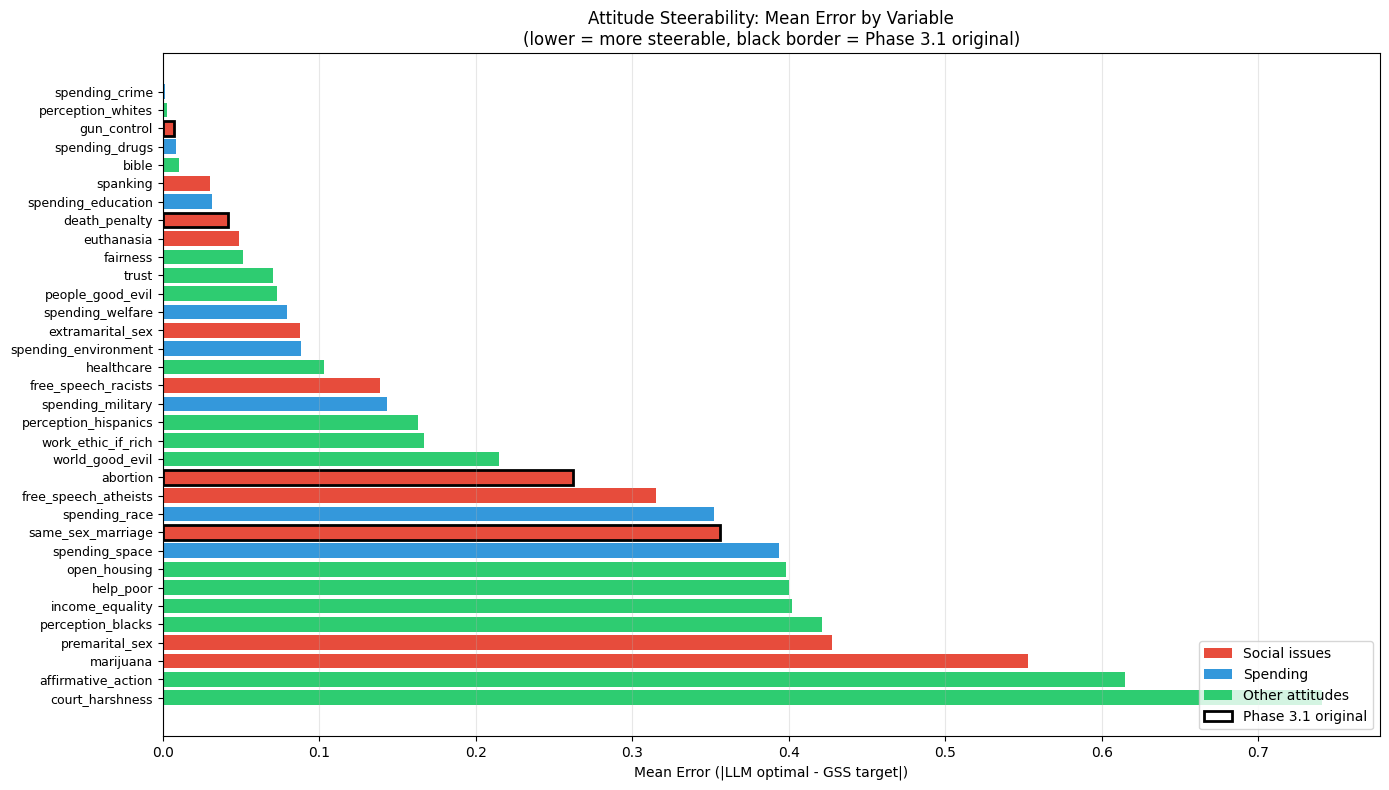

In [11]:
# Steerability summary bar chart
GROUP_COLORS = {
    'Social issues': '#E74C3C',
    'Spending': '#3498DB',
    'Other attitudes': '#2ECC71',
}

# Highlight the 4 original variables from Phase 3.1
ORIGINAL_VARS = {'abortion', 'gun_control', 'death_penalty', 'same_sex_marriage'}

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.barh(
    range(len(metrics_df)),
    metrics_df['mean_error'],
    color=[GROUP_COLORS.get(row['group'], '#888') for _, row in metrics_df.iterrows()],
    edgecolor=['black' if row['variable'] in ORIGINAL_VARS else 'none'
               for _, row in metrics_df.iterrows()],
    linewidth=[2 if row['variable'] in ORIGINAL_VARS else 0
               for _, row in metrics_df.iterrows()],
)

ax.set_yticks(range(len(metrics_df)))
ax.set_yticklabels([f'{row["variable"]}' for _, row in metrics_df.iterrows()], fontsize=9)
ax.set_xlabel('Mean Error (|LLM optimal - GSS target|)')
ax.set_title('Attitude Steerability: Mean Error by Variable\n(lower = more steerable, black border = Phase 3.1 original)')
ax.invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=g) for g, c in GROUP_COLORS.items()]
legend_elements.append(Patch(facecolor='white', edgecolor='black', linewidth=2, label='Phase 3.1 original'))
ax.legend(handles=legend_elements, loc='lower right')

ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Loaded 96 attitude vectors from layer 13


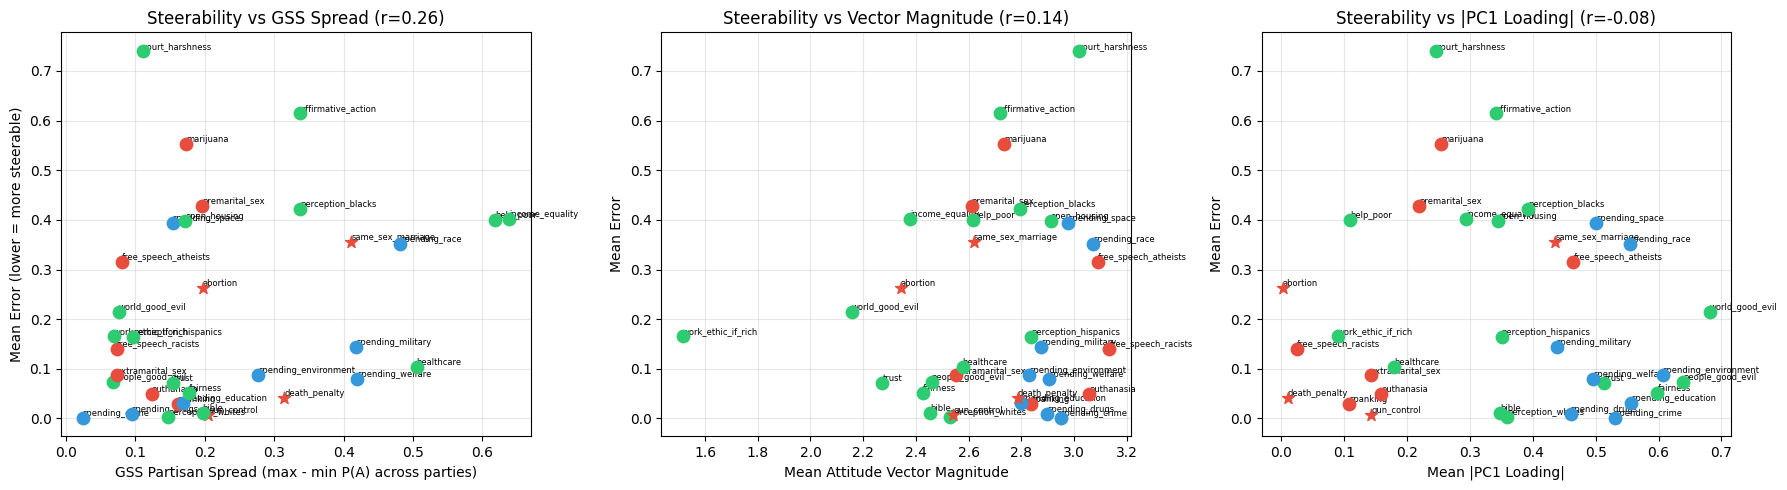

In [12]:
# Correlation analysis: what predicts steerability?

# Load attitude vectors for magnitude and PC loading analysis
try:
    att_vectors = torch.load(
        os.path.join(VECTOR_DIR, f'gss_attitude_vectors_layer{STEERING_LAYER}.pt'),
        map_location='cpu', weights_only=True,
    )
    has_att_vectors = True
    print(f'Loaded {len(att_vectors)} attitude vectors from layer {STEERING_LAYER}')
except FileNotFoundError:
    has_att_vectors = False
    print('Attitude vectors not found, skipping magnitude/PC analysis')

fig, axes = plt.subplots(1, 3 if has_att_vectors else 1, figsize=(18 if has_att_vectors else 7, 5))
if not isinstance(axes, np.ndarray):
    axes = [axes]

# --- Panel 1: Steerability vs GSS partisan spread ---
ax = axes[0]
for _, row in metrics_df.iterrows():
    color = GROUP_COLORS.get(row['group'], '#888')
    marker = '*' if row['variable'] in ORIGINAL_VARS else 'o'
    ax.scatter(row['gss_spread'], row['mean_error'], c=color, marker=marker, s=80, zorder=5)
    ax.annotate(row['variable'], (row['gss_spread'], row['mean_error']),
                fontsize=6, ha='left', va='bottom')

corr = metrics_df[['gss_spread', 'mean_error']].corr().iloc[0, 1]
ax.set_xlabel('GSS Partisan Spread (max - min P(A) across parties)')
ax.set_ylabel('Mean Error (lower = more steerable)')
ax.set_title(f'Steerability vs GSS Spread (r={corr:.2f})')
ax.grid(True, alpha=0.3)

if has_att_vectors:
    # Build a mapping from variable name to attitude vector label prefix
    # Attitude vectors are keyed like "Abortion_pro-choice person", "natspac_too little"
    att_labels = sorted(att_vectors.keys())

    # Compute mean magnitude per GSS variable category
    var_magnitudes = {}
    for var_name in active_vars:
        config = ATTITUDE_CONFIGS[var_name]
        gss_col = config['gss_col']
        # Try matching category prefix in attitude vector labels
        mags = [att_vectors[lab]['magnitude'] for lab in att_labels
                if lab.split('_')[0] == gss_col or lab.split('_')[0] == var_name.replace('_', '')]
        # Also try common mappings
        category_map = {
            'abortion': 'Abortion', 'gun_control': 'GunControl',
            'death_penalty': 'DeathPenalty', 'same_sex_marriage': 'SameSexMarriage',
        }
        alt = category_map.get(var_name)
        if alt:
            mags += [att_vectors[lab]['magnitude'] for lab in att_labels if lab.split('_')[0] == alt]
        var_magnitudes[var_name] = np.mean(mags) if mags else None

    # --- Panel 2: Steerability vs attitude vector magnitude ---
    ax = axes[1]
    mag_data = [(row['variable'], var_magnitudes.get(row['variable']), row['mean_error'], row['group'])
                for _, row in metrics_df.iterrows() if var_magnitudes.get(row['variable']) is not None]
    if mag_data:
        for vname, mag, err, group in mag_data:
            color = GROUP_COLORS.get(group, '#888')
            marker = '*' if vname in ORIGINAL_VARS else 'o'
            ax.scatter(mag, err, c=color, marker=marker, s=80, zorder=5)
            ax.annotate(vname, (mag, err), fontsize=6, ha='left', va='bottom')

        mags_arr = np.array([d[1] for d in mag_data])
        errs_arr = np.array([d[2] for d in mag_data])
        corr_mag = np.corrcoef(mags_arr, errs_arr)[0, 1]
        ax.set_title(f'Steerability vs Vector Magnitude (r={corr_mag:.2f})')
    else:
        ax.set_title('Steerability vs Vector Magnitude (no data)')
    ax.set_xlabel('Mean Attitude Vector Magnitude')
    ax.set_ylabel('Mean Error')
    ax.grid(True, alpha=0.3)

    # --- Panel 3: Steerability vs PC1 loading ---
    # Compute PCA on centered attitude vectors
    from sklearn.decomposition import PCA
    X = np.array([att_vectors[lab]['vector'].numpy() * att_vectors[lab]['magnitude']
                  for lab in att_labels])
    categories = [lab.split('_')[0] for lab in att_labels]
    unique_cats = sorted(set(categories))

    # Within-category centering
    X_centered = X.copy()
    for cat in unique_cats:
        mask = np.array([c == cat for c in categories])
        if mask.sum() > 1:
            X_centered[mask] -= X[mask].mean(axis=0)

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_centered)

    # Map each active variable to its mean absolute PC1 loading
    var_pc1 = {}
    for var_name in active_vars:
        config = ATTITUDE_CONFIGS[var_name]
        gss_col = config['gss_col']
        category_map = {
            'abortion': 'Abortion', 'gun_control': 'GunControl',
            'death_penalty': 'DeathPenalty', 'same_sex_marriage': 'SameSexMarriage',
        }
        alt = category_map.get(var_name)
        idxs = [i for i, lab in enumerate(att_labels)
                if lab.split('_')[0] == gss_col or (alt and lab.split('_')[0] == alt)]
        if idxs:
            var_pc1[var_name] = np.mean(np.abs(X_pca[idxs, 0]))

    ax = axes[2]
    pc1_data = [(row['variable'], var_pc1.get(row['variable']), row['mean_error'], row['group'])
                for _, row in metrics_df.iterrows() if var_pc1.get(row['variable']) is not None]
    if pc1_data:
        for vname, pc1_val, err, group in pc1_data:
            color = GROUP_COLORS.get(group, '#888')
            marker = '*' if vname in ORIGINAL_VARS else 'o'
            ax.scatter(pc1_val, err, c=color, marker=marker, s=80, zorder=5)
            ax.annotate(vname, (pc1_val, err), fontsize=6, ha='left', va='bottom')

        pc1_arr = np.array([d[1] for d in pc1_data])
        errs_arr = np.array([d[2] for d in pc1_data])
        corr_pc1 = np.corrcoef(pc1_arr, errs_arr)[0, 1]
        ax.set_title(f'Steerability vs |PC1 Loading| (r={corr_pc1:.2f})')
    else:
        ax.set_title('Steerability vs |PC1 Loading| (no data)')
    ax.set_xlabel('Mean |PC1 Loading|')
    ax.set_ylabel('Mean Error')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

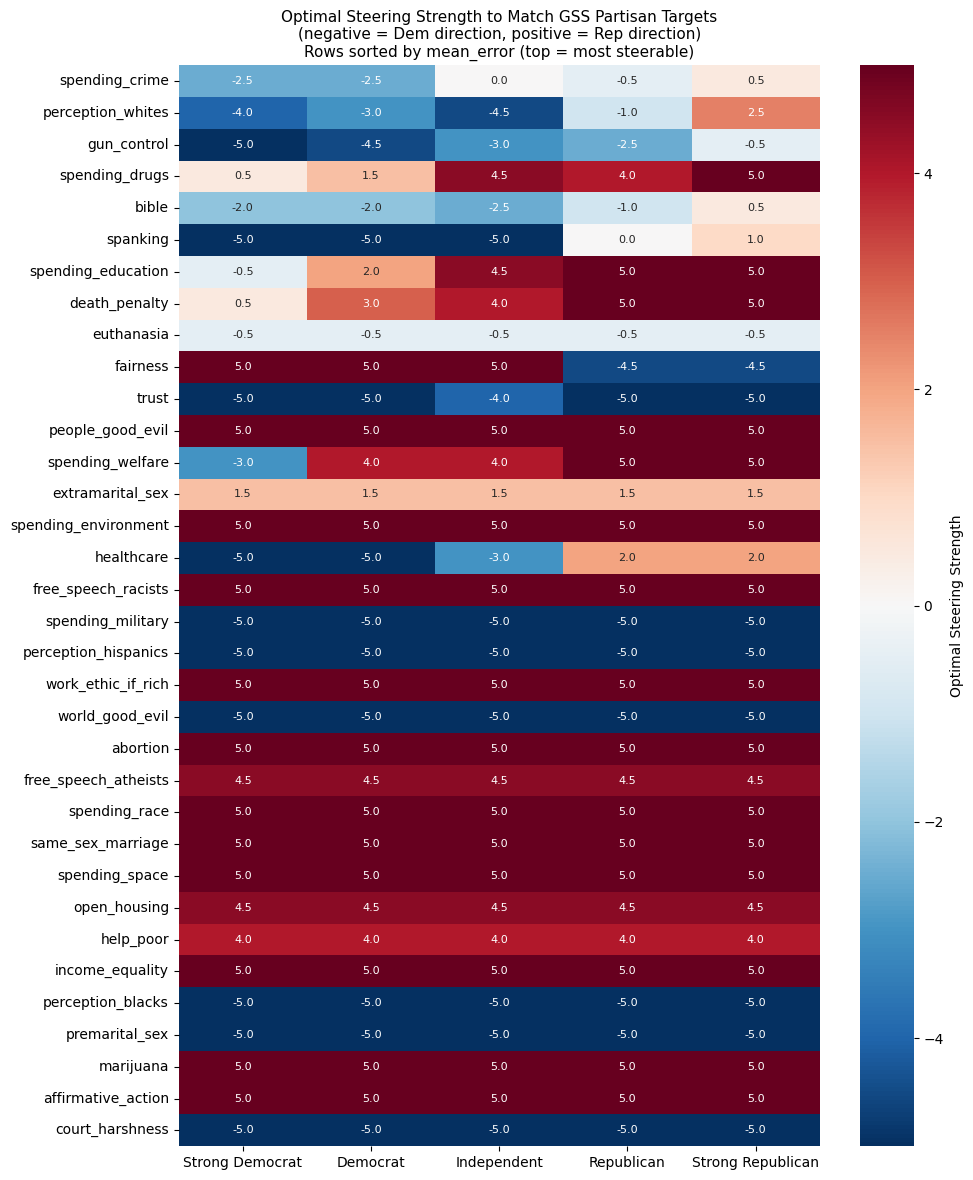

In [13]:
# Heatmap: Optimal Steering Strength per Variable × Party
optimal_data = []

for var_name in metrics_df['variable']:  # Already sorted by mean_error
    row = {'variable': var_name}
    llm_df = llm_steering_results[var_name]
    var_gss = gss_probs[var_name]

    for party_name in PARTYID_MAPPING:
        target = var_gss.get(party_name, {}).get('prob_a')
        strength, _ = find_optimal_strength(llm_df, target)
        row[party_name] = strength

    optimal_data.append(row)

optimal_df = pd.DataFrame(optimal_data).set_index('variable')

fig, ax = plt.subplots(figsize=(10, max(8, len(optimal_df) * 0.35)))
sns.heatmap(
    optimal_df.astype(float),
    cmap='RdBu_r', center=0, vmin=-5, vmax=5,
    annot=True, fmt='.1f', annot_kws={'size': 8},
    cbar_kws={'label': 'Optimal Steering Strength'},
    ax=ax,
)
ax.set_title('Optimal Steering Strength to Match GSS Partisan Targets\n'
             '(negative = Dem direction, positive = Rep direction)\n'
             'Rows sorted by mean_error (top = most steerable)', fontsize=11)
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Summary

### Key Findings

**Steerability metrics:**
- `mean_error`: average |LLM_optimal − GSS_target| across 5 parties (lower = more steerable)
- `llm_range`: max − min P(A) across all strengths (how much the vector moves this attitude)
- `gss_spread`: max − min P(A) across parties (how much real-world partisan variation exists)
- `all_reachable`: whether all 5 GSS targets fall within the LLM's achievable range

**Questions addressed:**
1. Which of the 34 attitude variables are most/least steerable to real-world partisan levels?
2. Do the 4 original Phase 3.1 variables (abortion, gun control, death penalty, same-sex marriage) reproduce their earlier results?
3. Does steerability correlate with attitude vector magnitude, PC1 loading, or real-world partisan spread?
4. Does the heatmap show the expected pattern (negative strengths for Dem targets, positive for Rep targets)?